# PRUEBA TECNICA JUAN ESTEBAN ACOSTA FRANCO

In [1]:
#Importar librerias
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score,confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Cargar los datos
df_train = pd.read_csv('C:/Users/ATENCION PQRS 2/Documents/JUANES/PRUEBA TECNICA/prueba-analitica-desbloqueo-de-cupos/base_entrenamiento.csv')
df_test = pd.read_csv('C:/Users/ATENCION PQRS 2/Documents/JUANES/PRUEBA TECNICA/prueba-analitica-desbloqueo-de-cupos/base_test.csv')
#variables_desc = pd.read_excel('C:/Users/ATENCION PQRS 2/Documents/JUANES/PRUEBA TECNICA/prueba-analitica-desbloqueo-de-cupos/descripcion_variables.xlsx')

# Mostrar las primeras filas de los datos
df_train.head()


C:\Users\ATENCION PQRS 2\AppData\Local\Temp\ipykernel_7340\1970723109.py:2: DtypeWarning: Columns (0,38,39,40,41,42,43,44,45,46,47,48,49,54,57,58,59,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('C:/Users/ATENCION PQRS 2/Documents/JUANES/PRUEBA TECNICA/prueba-analitica-desbloqueo-de-cupos/base_entrenamiento.csv')


,referencia_giro,nit_cliente,monto_giro,total_giros_mes,total_giros_ano,tope_mes,tope_ano,disponible_mes,disponible_ano,monto_usd,...,trimestre,ingresos_mensuales,riesgo_pais_residencia,riesgo_pais_nacim,riesgo_act_eco,pais_residencia_cat,pais_nacim_cat,porc_veces_pide_docs,porc_veces_envia_docs,y_desbloqueo
0,67fde2e3e822,-2.392080e+18,1000.50,2006.17,4588.72,3000.0,10000.0,993.83,5411.28,1000.50,...,4.0,5903189.070,MEDIO,MEDIO,BAJO,COLOMBIA,COLOMBIA,0.0,1.0,1.0
1,49c72e6ff080,6.552443e+18,58.42,637.57,12093.80,3000.0,10000.0,2362.43,-2093.80,58.42,...,4.0,0.000,MEDIO,MEDIO,MEDIO,COLOMBIA,COLOMBIA,0.0,1.0,1.0
2,2f7ca1cc9baec,7.660307e+16,817.07,2088.49,12364.40,3000.0,10000.0,911.51,-2364.40,817.07,...,4.0,3324972.701,MEDIO,MEDIO,MEDIO,COLOMBIA,COLOMBIA,0.0,1.0,1.0
3,719fa4ad,7.660307e+16,1040.58,1047.91,11323.82,3000.0,10000.0,1952.09,-1323.82,1040.58,...,4.0,3324972.701,MEDIO,MEDIO,MEDIO,COLOMBIA,COLOMBIA,0.0,1.0,1.0
4,a3405aacc7,1.830004e+18,1603.85,1792.82,7147.28,3000.0,10000.0,1207.18,2852.72,1603.85,...,3.0,1631757.647,MEDIO,MEDIO,BAJO,COLOMBIA,COLOMBIA,0.0,1.0,1.0


## ANALISIS EXPLORATORIO Y LIMPIEZA DE BASE_ENTRENAMIENTO

Revisaré la estructura de los datos  para ver cómo están distribuidos y detectar posibles problemas como valores nulos o datos inconsistentes.
El dataset de entrenamiento tiene 65 columnas y algunas presentan tipos de datos mixtos, lo que puede generar problemas en el análisis.

In [3]:
df_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 65 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   referencia_giro             79999 non-null  object 
 1   nit_cliente                 79999 non-null  float64
 2   monto_giro                  79999 non-null  float64
 3   total_giros_mes             79999 non-null  float64
 4   total_giros_ano             79999 non-null  float64
 5   tope_mes                    79999 non-null  float64
 6   tope_ano                    79999 non-null  float64
 7   disponible_mes              79999 non-null  float64
 8   disponible_ano              79999 non-null  float64
 9   monto_usd                   79999 non-null  float64
 10  ops_bloq                    79999 non-null  float64
 11  ordenantes_recibe_ops_bloq  79999 non-null  float64
 12  monto_recibido_bloq         79999 non-null  float64
 13  monto_promedio_bloq         79

### Tratamiento de los valores NULL 

In [4]:
df_train.isnull().sum()

referencia_giro          20001
nit_cliente              20001
monto_giro               20001
total_giros_mes          20001
total_giros_ano          20001
                         ...  
pais_residencia_cat      20001
pais_nacim_cat           20001
porc_veces_pide_docs     20001
porc_veces_envia_docs    20001
y_desbloqueo             20001
Length: 65, dtype: int64

#### Tratamiento de los valores NULL en la columna "y_desbloqueo"

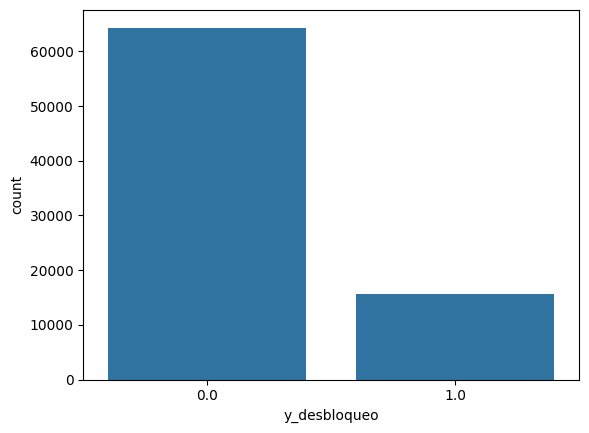

In [5]:
sns.countplot(x='y_desbloqueo', data=df_train)
plt.show()

In [6]:
# Revisar distribución de la variable objetivo
df_train["y_desbloqueo"].value_counts(dropna=False)

y_desbloqueo
0.0    64340
NaN    20001
1.0    15659
Name: count, dtype: int64

La variable objetivo "y_desbloqueo" tiene:

 - 64,340 valores en 0 (operaciones desbloqueadas).
 - 15,659 valores en 1 (operaciones no desbloqueadas).
 - 20,001 valores nulos, que eliminare para no afectar el entrenamiento.

In [7]:
# Eliminar filas con valores nulos en la variable objetivo
df_train = df_train.dropna(subset=["y_desbloqueo"])

# Verificar nuevamente valores nulos en el dataset
nulls_after_cleaning = df_train.isnull().sum()
nulls_after_cleaning[nulls_after_cleaning > 0]

desc_estado_civil_act         6262
desc_nivel_academico         47764
desc_calificacion_interna    79644
desc_segmento_sarlaft         8753
desc_subsegmento              4518
desc_cod_sector               1241
desc_estado_cliente            328
remesa                       35786
riesgo_pais_residencia           8
riesgo_pais_nacim                8
riesgo_act_eco                   8
dtype: int64

Opto por descartar los NULL para evitar problemas en el entrenamiento del modelo. Después de eliminar los valores nulos en "y_desbloqueo", encuentro otras columnas con datos faltantes

#### Tratamiento de los valores NULL en otras columnas

Se analiza el tipo de datos que hay en cada columna con valores faltantes para posteriormente decidir como tratarlas

In [8]:
# Revisar el tipo de datos de cada columna con valores nulos
df_train.dtypes[nulls_after_cleaning[nulls_after_cleaning > 0].index]

desc_estado_civil_act        object
desc_nivel_academico         object
desc_calificacion_interna    object
desc_segmento_sarlaft        object
desc_subsegmento             object
desc_cod_sector              object
desc_estado_cliente          object
remesa                       object
riesgo_pais_residencia       object
riesgo_pais_nacim            object
riesgo_act_eco               object
dtype: object

Las columnas con valores nulos son de tipo categoría (object).

Opciones para tratarlas:

1. Si la variable es importante → Reemplazar nulos con "DESCONOCIDO".
2. Si la variable no aporta mucho → Eliminarla.
3. Si la variable tiene un patrón lógico → Rellenar con la moda.

No se puede usar la media o mediana porque las variables son categóricas, la media y la mediana solo tienen sentido en datos numéricos.

No es necesario un modelo predictivo de imputación, porque los valores nulos no son lo suficientemente numerosos ni complejos como para justificar el uso de un modelo más avanzado. Técnicas como KNN Imputer o regresión logística para imputación podrían usarse si los datos fueran extremadamente dispersos o si hubiera relaciones muy fuertes entre variables.

Sin embargo, en este caso, hay pocas categorías (entre 3 y 15 en la mayoría de las variables), lo que hace que la moda sea una opción confiable y estable sin necesidad de sobrecomplicar el proceso. Imputar con la moda es rápido y fácil de implementar sin afectar el rendimiento. No requiere modelos adicionales ni cálculos costosos y permite que el pipeline de datos se mantenga simple y eficiente.

Voy a revisar la cantidad de valores únicos en estas columnas para tomar una mejor decisión

In [9]:
# Contar valores únicos en las columnas con nulos
unique_values = {col: df_train[col].nunique() for col in nulls_after_cleaning[nulls_after_cleaning > 0].index}
unique_values

{'desc_estado_civil_act': 7,
 'desc_nivel_academico': 7,
 'desc_calificacion_interna': 32,
 'desc_segmento_sarlaft': 8,
 'desc_subsegmento': 15,
 'desc_cod_sector': 11,
 'desc_estado_cliente': 3,
 'remesa': 17,
 'riesgo_pais_residencia': 4,
 'riesgo_pais_nacim': 5,
 'riesgo_act_eco': 4}

Las columnas con nulos tienen entre 3 y 32 valores únicos.

Dada la naturaleza de la variable, la cantidad de NULLS y la cantidad de valores unicos, se decide procesar los valores NULLS asi:

1. Reemplazo por "DESCONOCIDOS" columnas: 'desc_estado_civil_act', 'desc_segmento_sarlaft', 'remesa'. Estas columnas tienen una cantidad considerable de valores nulos, pero también tienen un número limitado de categorías únicas (entre 7 y 17).
    - 'desc_estado_civil_act' (6262 nulos, 7 categorías) → No es una cantidad extremadamente alta de nulos en comparación con la población total, por lo que "DESCONOCIDO" puede representar un estado válido sin sesgar el modelo.
    - 'desc_segmento_sarlaft' (8753 nulos, 8 categorías) → Con pocas categorías, asignar la moda podría distorsionar la distribución real de la variable. "DESCONOCIDO" preserva la incertidumbre.
    - 'remesa' (35786 nulos, 17 categorías) → Dado que la mitad de los datos no tienen información, imputar la moda sesgaría la distribución. "DESCONOCIDO" permite diferenciar entre quienes tienen o no datos en esta variable.


1. Remplazo por la MODA los nulls de las columnas 'desc_nivel_academico', 'desc_subsegmento', 'desc_cod_sector', 'desc_estado_cliente'. Estas columnas tienen una cantidad moderada de valores nulos y pocas categorías únicas.

    - 'desc_nivel_academico' (47764 nulos, 7 categorías) → La cantidad de nulos es alta, pero pocas categorías permiten que la moda represente adecuadamente la distribución real.
    - 'desc_subsegmento' (4518 nulos, 15 categorías) → Reemplazar por la moda minimiza la distorsión, ya que la variable tiene suficientes categorías para mantener variabilidad.
    - 'desc_cod_sector' (1241 nulos, 11 categorías) → Similar a 'desc_subsegmento', su cantidad moderada de valores únicos hace que la moda sea una opción viable.
    - 'desc_estado_cliente' (328 nulos, 3 categorías) → Como solo hay 3 valores posibles, la moda es una opción estable para la imputación sin perder información significativa.

3. Descarto los NULL de las columnas 'riesgo_pais_residencia', 'riesgo_pais_nacim', 'riesgo_act_eco'. Estas variables tienen muy pocos valores nulos (8 en cada una) y pocas categorías únicas (4 o 5).
    - Con solo 8 valores nulos en un dataset grande, eliminar esas filas no afectará significativamente el tamaño de la muestra.
    - Como estas variables tienen pocas categorías, imputar con la moda podría alterar su distribución, lo que no es recomendable si son factores críticos en el modelo.

In [10]:
# Reemplazar nulos con "desconocido" en las columnas específicas
columnas_desconocido = ['desc_estado_civil_act', 'desc_segmento_sarlaft', 'remesa']
df_train[columnas_desconocido] = df_train[columnas_desconocido].fillna("DESCONOCIDO")

# Reemplazar nulos con la moda en las columnas específicas
columnas_moda = ['desc_nivel_academico', 'desc_subsegmento', 'desc_cod_sector', 'desc_estado_cliente']
for col in columnas_moda:
    moda = df_train[col].mode()[0]  # Obtener la moda de la columna
    df_train[col] = df_train[col].fillna(moda)

# Eliminar registros con valores nulos en estas columnas
columnas_eliminar = ['riesgo_pais_residencia', 'riesgo_pais_nacim', 'riesgo_act_eco']
df_train = df_train.dropna(subset=columnas_eliminar)

# Verificar que se hayan aplicado correctamente los cambios
print(df_train.isnull().sum())  # Esto mostrará cuántos nulos quedan en cada columna


referencia_giro          0
nit_cliente              0
monto_giro               0
total_giros_mes          0
total_giros_ano          0
                        ..
pais_residencia_cat      0
pais_nacim_cat           0
porc_veces_pide_docs     0
porc_veces_envia_docs    0
y_desbloqueo             0
Length: 65, dtype: int64


### Columnas irrelevantes

Elimino la columna desc_calificacion_interna, mas del 90% de sus campos eran NULL

In [11]:
df_train.drop(columns=['desc_calificacion_interna'], inplace=True)

Revision de la cantidad de NULL en el dataset 

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79991 entries, 0 to 79998
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   referencia_giro             79991 non-null  object 
 1   nit_cliente                 79991 non-null  float64
 2   monto_giro                  79991 non-null  float64
 3   total_giros_mes             79991 non-null  float64
 4   total_giros_ano             79991 non-null  float64
 5   tope_mes                    79991 non-null  float64
 6   tope_ano                    79991 non-null  float64
 7   disponible_mes              79991 non-null  float64
 8   disponible_ano              79991 non-null  float64
 9   monto_usd                   79991 non-null  float64
 10  ops_bloq                    79991 non-null  float64
 11  ordenantes_recibe_ops_bloq  79991 non-null  float64
 12  monto_recibido_bloq         79991 non-null  float64
 13  monto_promedio_bloq         79991 no

#### Revision si alguna columna categórica o numerica es de un unico nivel o valor

1. Columnas numericas

In [13]:
df_train.describe()

,nit_cliente,monto_giro,total_giros_mes,total_giros_ano,tope_mes,tope_ano,disponible_mes,disponible_ano,monto_usd,ops_bloq,...,prom_monto_remesas,dia,mes,annio,hora,trimestre,ingresos_mensuales,porc_veces_pide_docs,porc_veces_envia_docs,y_desbloqueo
count,7.999100e+04,7.999100e+04,7.999100e+04,7.999100e+04,79991.000000,79991.00000,7.999100e+04,7.999100e+04,7.999100e+04,79991.000000,...,79991.000000,79991.000000,79991.000000,79991.000000,79991.000000,79991.000000,7.999100e+04,79991.000000,79991.000000,79991.000000
mean,-4.564499e+16,7.473023e+03,3.180211e+03,2.582182e+04,7961.452501,34375.29222,4.781242e+03,8.553471e+03,7.409767e+03,3.260029,...,692.203466,17.033529,9.403320,2024.105687,15.592229,3.423498,4.901794e+06,0.059595,0.947834,0.195685
std,5.318240e+18,4.561336e+04,1.149040e+04,5.519639e+04,5752.146328,47627.65920,1.175970e+04,6.407886e+04,4.467419e+04,2.032082,...,1395.145306,9.146616,3.097717,0.307438,4.234047,0.937166,9.343206e+06,0.205162,0.216320,0.396729
min,-9.223320e+18,2.000000e-01,-4.000000e+03,0.000000e+00,3000.000000,10000.00000,-1.560000e+06,-7.089985e+06,2.000000e-01,1.000000,...,0.000000,1.000000,1.000000,2024.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,-4.656230e+18,7.000000e+02,0.000000e+00,9.731280e+03,6999.000000,28000.00000,2.162565e+03,-1.058230e+03,7.000000e+02,2.000000,...,0.000000,9.000000,9.000000,2024.000000,13.000000,3.000000,1.553851e+06,0.000000,1.000000,0.000000
50%,-4.724480e+16,2.025430e+03,3.908800e+02,2.694972e+04,6999.000000,28000.00000,6.356430e+03,7.185900e+02,2.033800e+03,3.000000,...,310.774568,18.000000,10.000000,2024.000000,15.000000,4.000000,2.882664e+06,0.000000,1.000000,0.000000
75%,4.527346e+18,5.422490e+03,4.454285e+03,2.942794e+04,6999.000000,28000.00000,6.999000e+03,1.759329e+04,5.431495e+03,5.000000,...,901.541111,25.000000,12.000000,2024.000000,19.000000,4.000000,5.542430e+06,0.000000,1.000000,0.000000
max,9.222847e+18,6.500000e+06,1.600000e+06,7.489985e+06,40000.000000,400000.00000,4.000000e+04,4.000000e+05,6.500000e+06,34.000000,...,54305.370000,31.000000,12.000000,2025.000000,23.000000,4.000000,2.000000e+08,1.000000,2.000000,1.000000


Observando la desviacion estandar se puede concluir si en las columnas numericas hay alguna que tuviera un solo valor

2. Columnas categoricas

In [14]:
columnas_categoricas = df_train.select_dtypes(include=['object']).columns

for col in columnas_categoricas:
  print(f'Columna {col}: {df_train[col].nunique()} subniveles')


Columna referencia_giro: 79991 subniveles
Columna segmento: 5 subniveles
Columna moneda: 7 subniveles
Columna tipo_documento: 7 subniveles
Columna desc_estado_civil_act: 8 subniveles
Columna desc_nivel_academico: 7 subniveles
Columna desc_segmento_sarlaft: 9 subniveles
Columna desc_subsegmento: 15 subniveles
Columna desc_cod_sector: 11 subniveles
Columna desc_estado_cliente: 3 subniveles
Columna lugar_residencia: 2 subniveles
Columna remesa: 18 subniveles
Columna dia_semana: 7 subniveles
Columna riesgo_pais_residencia: 4 subniveles
Columna riesgo_pais_nacim: 5 subniveles
Columna riesgo_act_eco: 4 subniveles
Columna pais_residencia_cat: 4 subniveles
Columna pais_nacim_cat: 5 subniveles


Todas las colmunas categoricas tienen mas de un nivel, por lo tanto ninguna es irrelevante

#### Detectar columnas con datos mixtos

In [15]:
for col in df_train.columns:
    tipos = df_train[col].apply(type).value_counts()
    if len(tipos) > 1:  # Si hay más de un tipo de dato
        print(f"La columna '{col}' tiene múltiples tipos de datos:")
        print(tipos, "\n")

### Revisión filas repetidas

In [16]:
print(f'Tamaño del set antes de eliminar las filas repetidas: {df_train.shape}')
df_train.drop_duplicates(inplace=True)
print(f'Tamaño del set después de eliminar las filas repetidas: {df_train.shape}')

Tamaño del set antes de eliminar las filas repetidas: (79991, 64)
Tamaño del set después de eliminar las filas repetidas: (79991, 64)


No hay filas repetidas

### Outliners - Valores extremos

C:\Users\ATENCION PQRS 2\AppData\Local\Temp\ipykernel_7340\826193786.py:24: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout(pad=9.0)  # Aumentar el espacio entre los gráficos


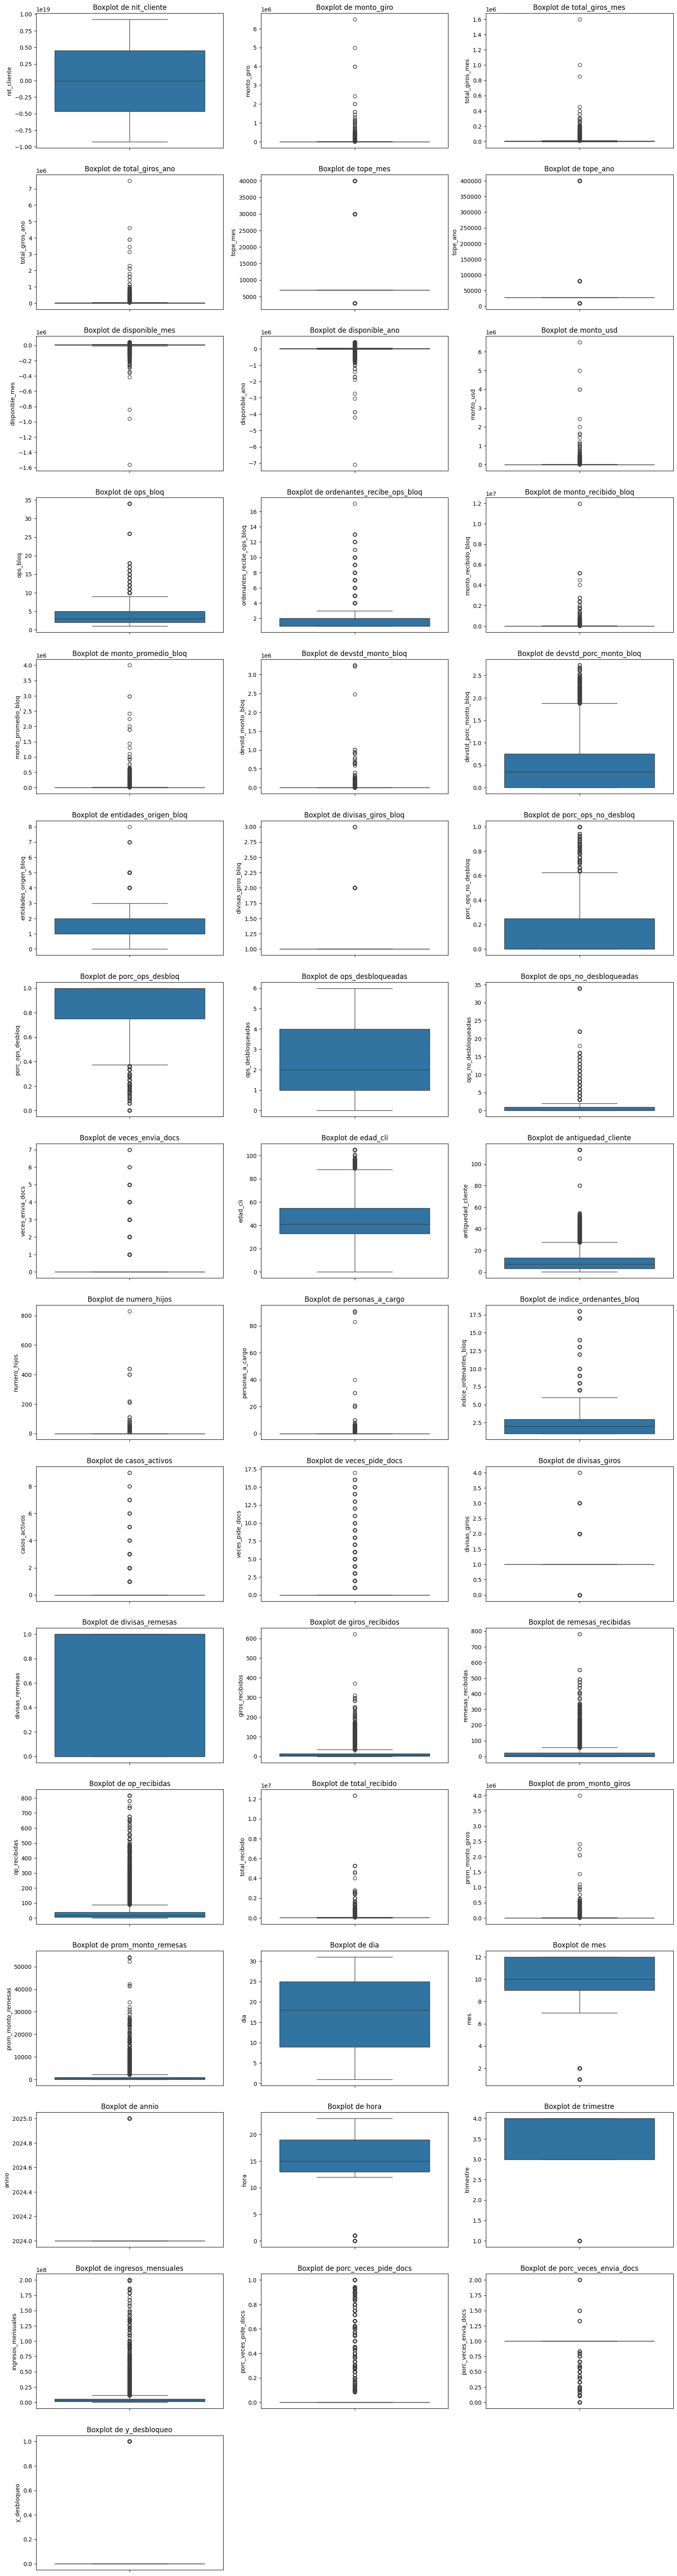

In [17]:
# Seleccionar solo las columnas numéricas
columnas_numericas = df_train.select_dtypes(include=['number']).columns

# Determinar el número de filas y columnas para los subgráficos
num_graficos = len(columnas_numericas)
num_columnas = 3  # Número de columnas que quieres en la cuadrícula
num_filas = (num_graficos // num_columnas) + (num_graficos % num_columnas != 0)  # Redondear hacia arriba si no es divisible

# Crear la figura y los ejes para los subgráficos
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(20, 16))  # Ajusta el tamaño de la figura (más grande)
axes = axes.flatten()  # Aplana el arreglo de ejes para poder iterar sobre él fácilmente

# Crear gráficos para cada variable numérica
for i, col in enumerate(columnas_numericas):
    sns.boxplot(y=df_train[col], ax=axes[i])  # Asigna cada gráfico a un eje
    axes[i].set_title(f"Boxplot de {col}", fontsize=12)  # Título con el nombre de la columna
    axes[i].tick_params(axis='x', rotation=45)  # Rotar las etiquetas del eje X para evitar que se amontonen

# Eliminar los ejes no utilizados si hay menos gráficos que subgráficos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el espacio entre los subgráficos para evitar la superposición de títulos
plt.tight_layout(pad=9.0)  # Aumentar el espacio entre los gráficos
fig.subplots_adjust(top=4)  # Ajustar el espacio superior para dar más margen a los títulos
plt.show()


In [18]:

# Seleccionar solo las columnas numéricas
columnas_numericas = df_train.select_dtypes(include=['number']).columns

# Diccionario para almacenar outliers detectados
outliers_detectados = {}

for col in columnas_numericas:
    Q1 = df_train[col].quantile(0.25)  # Percentil 25
    Q3 = df_train[col].quantile(0.75)  # Percentil 75
    IQR = Q3 - Q1  # Rango Intercuartílico
    
    # Definir límites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Filtrar outliers
    outliers = df_train[(df_train[col] < limite_inferior) | (df_train[col] > limite_superior)]
    
    # Guardar la cantidad de outliers por columna
    outliers_detectados[col] = len(outliers)

# Mostrar cantidad de outliers por columna
outliers_detectados


{'nit_cliente': 0,
 'monto_giro': 8115,
 'total_giros_mes': 3051,
 'total_giros_ano': 3711,
 'tope_mes': 8538,
 'tope_ano': 8538,
 'disponible_mes': 4974,
 'disponible_ano': 4099,
 'monto_usd': 8105,
 'ops_bloq': 562,
 'ordenantes_recibe_ops_bloq': 4552,
 'monto_recibido_bloq': 7924,
 'monto_promedio_bloq': 8017,
 'devstd_monto_bloq': 11110,
 'devstd_porc_monto_bloq': 830,
 'entidades_origen_bloq': 1155,
 'divisas_giros_bloq': 1440,
 'porc_ops_no_desbloq': 10998,
 'porc_ops_desbloq': 10998,
 'ops_desbloqueadas': 0,
 'ops_no_desbloqueadas': 5074,
 'veces_envia_docs': 4533,
 'edad_cli': 1481,
 'antiguedad_cliente': 4427,
 'numero_hijos': 7472,
 'personas_a_cargo': 7688,
 'indice_ordenantes_bloq': 583,
 'casos_activos': 4148,
 'veces_pide_docs': 7993,
 'divisas_giros': 15655,
 'divisas_remesas': 0,
 'giros_recibidos': 6069,
 'remesas_recibidas': 6331,
 'op_recibidas': 7048,
 'total_recibido': 8074,
 'prom_monto_giros': 8751,
 'prom_monto_remesas': 4821,
 'dia': 0,
 'mes': 8454,
 'annio': 

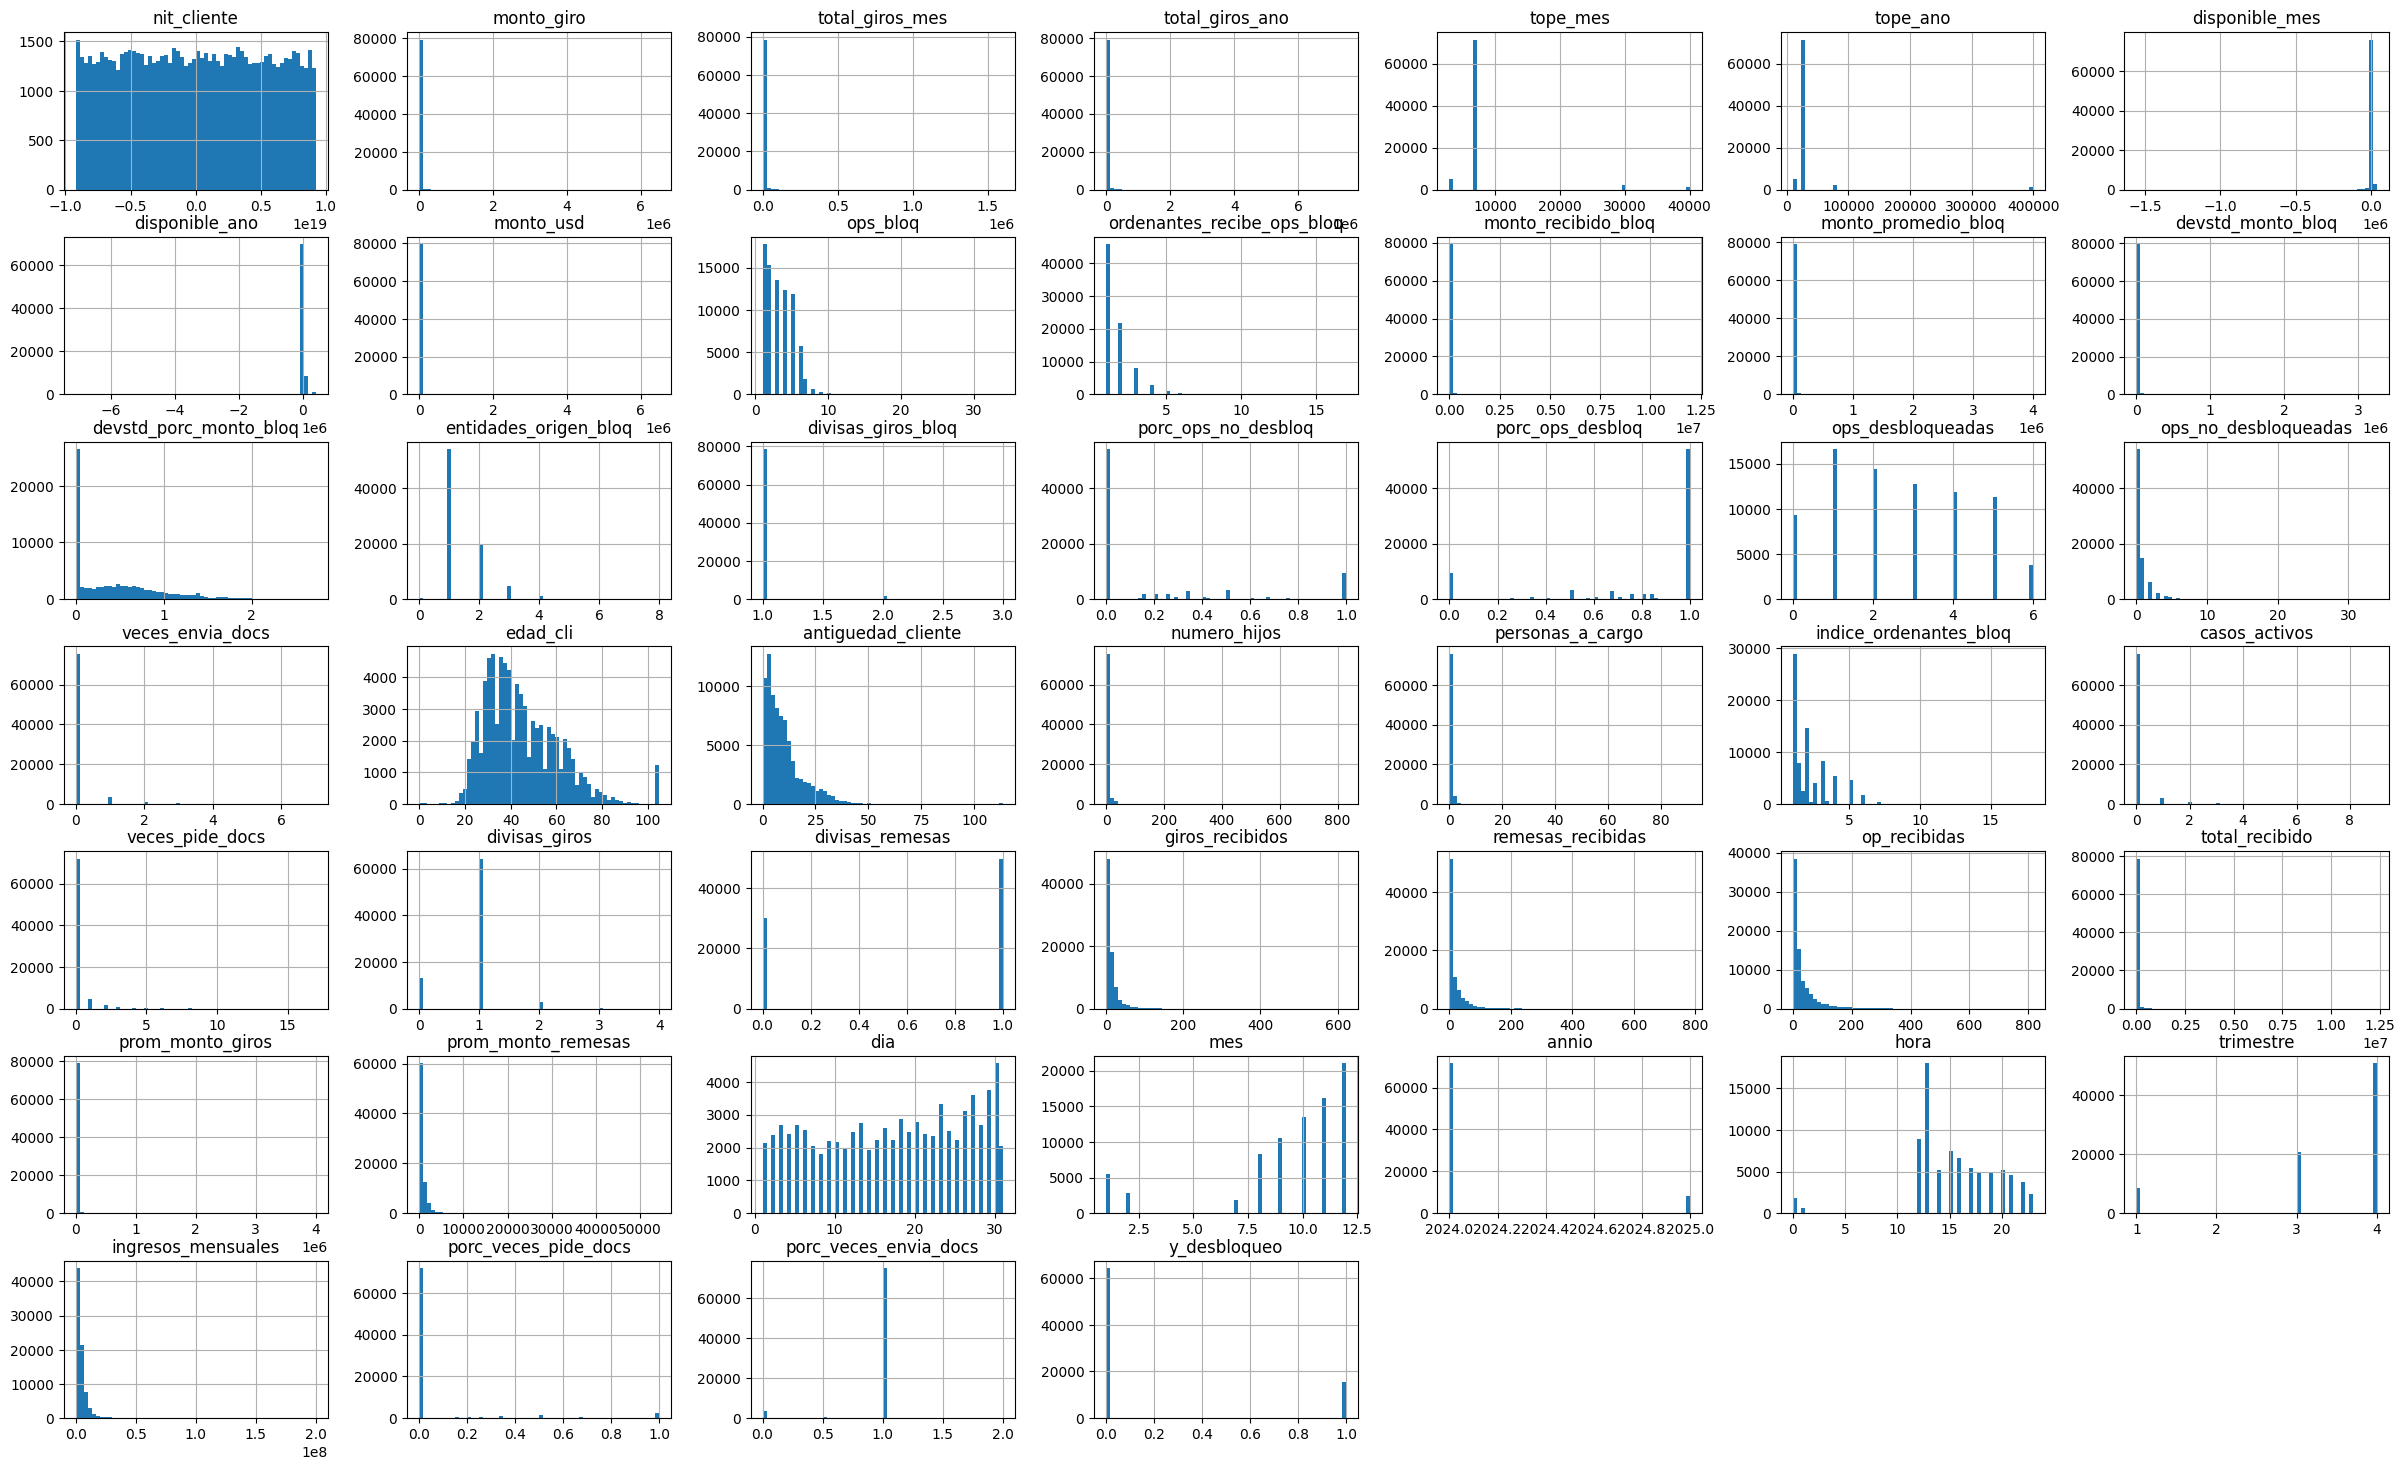

In [19]:
df_train.hist(figsize=(30, 18), bins=60)
plt.show()

In [20]:
# Descripción estadística de las columnas con valores atípicos
columnas_outliers = [
    'monto_giro', 'total_giros_mes', 'total_giros_ano', 'tope_mes', 'tope_ano', 
    'disponible_mes', 'disponible_ano', 'monto_usd', 'ops_bloq', 'ordenantes_recibe_ops_bloq', 
    'monto_recibido_bloq', 'monto_promedio_bloq', 'devstd_monto_bloq', 'devstd_porc_monto_bloq', 
    'entidades_origen_bloq', 'divisas_giros_bloq', 'porc_ops_no_desbloq', 'porc_ops_desbloq', 
    'ops_no_desbloqueadas', 'veces_envia_docs', 'edad_cli', 'antiguedad_cliente', 'numero_hijos', 
    'personas_a_cargo', 'indice_ordenantes_bloq', 'casos_activos', 'veces_pide_docs', 'divisas_giros', 
    'giros_recibidos', 'remesas_recibidas', 'op_recibidas', 'total_recibido', 'prom_monto_giros', 
    'prom_monto_remesas', 'mes', 'annio', 'hora', 'trimestre', 'ingresos_mensuales', 
    'porc_veces_pide_docs', 'porc_veces_envia_docs', 'y_desbloqueo'
]

df_train[columnas_outliers].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])


,monto_giro,total_giros_mes,total_giros_ano,tope_mes,tope_ano,disponible_mes,disponible_ano,monto_usd,ops_bloq,ordenantes_recibe_ops_bloq,...,prom_monto_giros,prom_monto_remesas,mes,annio,hora,trimestre,ingresos_mensuales,porc_veces_pide_docs,porc_veces_envia_docs,y_desbloqueo
count,7.999100e+04,7.999100e+04,7.999100e+04,79991.000000,79991.00000,7.999100e+04,7.999100e+04,7.999100e+04,79991.000000,79991.000000,...,7.999100e+04,79991.000000,79991.000000,79991.000000,79991.000000,79991.000000,7.999100e+04,79991.000000,79991.000000,79991.000000
mean,7.473023e+03,3.180211e+03,2.582182e+04,7961.452501,34375.29222,4.781242e+03,8.553471e+03,7.409767e+03,3.260029,1.684389,...,6.212287e+03,692.203466,9.403320,2024.105687,15.592229,3.423498,4.901794e+06,0.059595,0.947834,0.195685
std,4.561336e+04,1.149040e+04,5.519639e+04,5752.146328,47627.65920,1.175970e+04,6.407886e+04,4.467419e+04,2.032082,1.047468,...,3.021075e+04,1395.145306,3.097717,0.307438,4.234047,0.937166,9.343206e+06,0.205162,0.216320,0.396729
min,2.000000e-01,-4.000000e+03,0.000000e+00,3000.000000,10000.00000,-1.560000e+06,-7.089985e+06,2.000000e-01,1.000000,1.000000,...,0.000000e+00,0.000000,1.000000,2024.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000
1%,2.727000e+01,0.000000e+00,0.000000e+00,3000.000000,10000.00000,-1.800100e+04,-7.366384e+04,2.727000e+01,1.000000,1.000000,...,0.000000e+00,0.000000,1.000000,2024.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.000000e+02,0.000000e+00,9.731280e+03,6999.000000,28000.00000,2.162565e+03,-1.058230e+03,7.000000e+02,2.000000,1.000000,...,3.429020e+02,0.000000,9.000000,2024.000000,13.000000,3.000000,1.553851e+06,0.000000,1.000000,0.000000
50%,2.025430e+03,3.908800e+02,2.694972e+04,6999.000000,28000.00000,6.356430e+03,7.185900e+02,2.033800e+03,3.000000,1.000000,...,1.602430e+03,310.774568,10.000000,2024.000000,15.000000,4.000000,2.882664e+06,0.000000,1.000000,0.000000
75%,5.422490e+03,4.454285e+03,2.942794e+04,6999.000000,28000.00000,6.999000e+03,1.759329e+04,5.431495e+03,5.000000,2.000000,...,4.511667e+03,901.541111,12.000000,2024.000000,19.000000,4.000000,5.542430e+06,0.000000,1.000000,0.000000
99%,9.498500e+04,3.469089e+04,1.360000e+05,40000.000000,400000.00000,3.000000e+04,3.354670e+05,9.443488e+04,9.000000,5.000000,...,7.697150e+04,5749.095000,12.000000,2025.000000,23.000000,4.000000,3.599821e+07,1.000000,1.000000,1.000000
max,6.500000e+06,1.600000e+06,7.489985e+06,40000.000000,400000.00000,4.000000e+04,4.000000e+05,6.500000e+06,34.000000,17.000000,...,4.000000e+06,54305.370000,12.000000,2025.000000,23.000000,4.000000,2.000000e+08,1.000000,2.000000,1.000000


Se realiza un tratamiento exclusivamente a los valores extremo de la variable edad_cli

In [21]:
# Calcular la moda de la columna 'edad_cli'
moda_edad = df_train['edad_cli'].mode()[0]

# Reemplazar valores mayores a 100 con la moda
df_train.loc[df_train['edad_cli'] > 100, 'edad_cli'] = moda_edad

In [22]:
df_train['edad_cli'].describe()

count    79991.000000
mean        43.743234
std         14.684141
min          0.000000
25%         33.000000
50%         41.000000
75%         54.000000
max        100.000000
Name: edad_cli, dtype: float64

#### EXPLICACIÓN Y OBSERVACIONES


Se grafica histogramas y boxplots para conocer la distribucion y el impacto de los valores atipicos, en este caso estos valores los cosidero reales y no errores, de igual forma se revisan las estadisticas (mínimos, máximos, media, mediana) como apoyo a esta decision. Dado que valores atipicos como los de monto_giro pueden indicar informacion valiosa como fraudes o clientes "especiales".

Estos valores extremos podrian afectar mi modelo, esto  depende del modelo que seleccione, sin embargo eliminarlos o transformalos afectaria la veracidad de la informacion

#### Se compara con otras variables en busqueda de patrones clave y/o tendencias entre los datos:

1. Transacciones Financieras
   
Monto de Giros: Los montos de giro varían significativamente, desde valores pequeños (e.g., 17.67 USD) hasta montos muy altos (e.g., 97985 USD). Esto sugiere que hay una amplia gama de clientes, desde aquellos que realizan transacciones pequeñas hasta aquellos que manejan grandes sumas de dinero.

Frecuencia de Giros: Algunos clientes realizan múltiples transacciones en un mes, mientras que otros tienen una frecuencia más baja. Esto podría indicar diferentes patrones de uso del servicio.

Disponibilidad Mensual y Anual: Muchos clientes tienen un límite mensual y anual, y algunos han excedido estos límites (e.g., disponible_mes y disponible_ano negativos). 

2. Perfil del Cliente
   
Edad: La edad de los clientes varía desde 16 hasta 100 años, con una concentración en el rango de 20 a 50 años. Esto sugiere que el servicio es utilizado por una amplia gama de edades, pero con un enfoque en adultos jóvenes y de mediana edad.

Antigüedad del Cliente: La antigüedad de los clientes varía desde menos de un año hasta más de 30 años. Esto indica que hay tanto clientes nuevos como clientes de larga data.

Nivel Académico: La mayoría de los clientes tienen un nivel académico universitario, lo que sugiere que el servicio es más popular entre personas con educación superior.

Estado Civil: El estado civil de los clientes varía, con una presencia significativa de solteros, casados y personas en unión libre. Esto indica que el servicio es utilizado por personas en diferentes etapas de la vida.

3. Características Demográficas
   
Lugar de Residencia: La mayoría de los clientes residen en Colombia, aunque hay algunos casos de clientes que residen en el exterior (e.g., Estados Unidos). Esto sugiere que el servicio tiene un alcance internacional, aunque la mayoría de los usuarios son locales.

Riesgo País: El riesgo país de residencia y nacimiento es principalmente "MEDIO", lo que indica que los clientes provienen de países con un nivel de riesgo moderado.

4. Segmentación y Subsegmentación
   
Segmento SARLAFT: La mayoría de los clientes están clasificados en segmentos como "SOCIAL" y "PERSONAL", lo que sugiere que el servicio es utilizado tanto para transacciones personales como para negocios.

Subsegmento: Los subsegmentos varían desde "BÁSICO" hasta "ALTO", lo que indica diferentes niveles de riesgo asociados con los clientes.

5. Operaciones Bloqueadas y Desbloqueadas
   
Operaciones Bloqueadas: Algunos clientes tienen operaciones bloqueadas, lo que podría indicar problemas de cumplimiento o riesgos asociados con ciertas transacciones.

Operaciones Desbloqueadas: La mayoría de las operaciones están desbloqueadas, lo que sugiere que la mayoría de las transacciones son consideradas seguras.

6. Tendencias Temporales

   
Mes y Año: Las transacciones están distribuidas a lo largo del año, con una mayor concentración en los últimos meses del año (e.g., octubre, noviembre, diciembre). Esto podría indicar un aumento en la actividad financiera hacia el final del año, posiblemente relacionado con festividades o cierres de año.

8. Ingresos Mensuales


Ingresos Mensuales: Los ingresos mensuales de los clientes varían ampliamente, desde valores bajos hasta ingresos muy altos. Esto sugiere que el servicio es utilizado por personas con diferentes niveles de ingresos.

10. Riesgo de Actividad Económica

    
Riesgo de Actividad Económica: La mayoría de los clientes tienen un riesgo de actividad económica "BAJO" o "MEDIO", lo que indica que las transacciones están asociadas con actividades de bajo riesgo.

12. Divisas
    
Divisas: La mayoría de las transacciones están en USD, lo que sugiere que el servicio es utilizado principalmente para transacciones en dólares estadounidenses.



### Errores tipográficos en variables categóricas


En una variable categórica pueden aparecer sub-niveles como "pequqeño" y "peq" que son equivalentes pero para el programa parecerían diferentes.
Se deben unificar estos sub-niveles.

#### Solo se observa que hay datos escritos en minuscula, a diferencia de la mayoria de los demas que estan escritos en mayuscula, ademas que se observa que los dias de la semana estan en inglés, esto no represtena un error a tener en cuenta porque no hay mas sub-niveles con el mismo nombre.


In [23]:
'''# Graficar los subniveles de cada variable categórica
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

# Crear la figura y los ejes
fig, ax = plt.subplots(nrows=len(categorical_cols), ncols=1, figsize=(10, 30))
fig.subplots_adjust(hspace=1)

# Graficar la distribución de cada variable categórica
for i, col in enumerate(categorical_cols):
    sns.countplot(data=df_train, x=col, ax=ax[i], order=df_train[col].value_counts().index)
    ax[i].set_title(col)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30)

# Mostrar las gráficas
plt.show()'''


"# Graficar los subniveles de cada variable categórica\ncategorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()\n\n# Crear la figura y los ejes\nfig, ax = plt.subplots(nrows=len(categorical_cols), ncols=1, figsize=(10, 30))\nfig.subplots_adjust(hspace=1)\n\n# Graficar la distribución de cada variable categórica\nfor i, col in enumerate(categorical_cols):\n    sns.countplot(data=df_train, x=col, ax=ax[i], order=df_train[col].value_counts().index)\n    ax[i].set_title(col)\n    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30)\n\n# Mostrar las gráficas\nplt.show()"

In [24]:
corr_matrix = df_train.select_dtypes(include=['number']).corr()
print(corr_matrix["y_desbloqueo"].sort_values(ascending=False))

y_desbloqueo                  1.000000
porc_ops_no_desbloq           0.852446
ops_no_desbloqueadas          0.537478
divisas_remesas               0.219636
remesas_recibidas             0.184314
porc_veces_pide_docs          0.180491
veces_pide_docs               0.179251
op_recibidas                  0.169355
ordenantes_recibe_ops_bloq    0.095252
entidades_origen_bloq         0.064072
casos_activos                 0.051649
giros_recibidos               0.039568
monto_usd                     0.031458
monto_giro                    0.031033
prom_monto_giros              0.029793
monto_promedio_bloq           0.026741
monto_recibido_bloq           0.021025
devstd_monto_bloq             0.015837
total_recibido                0.015461
dia                           0.014222
hora                          0.009369
prom_monto_remesas            0.008375
ops_bloq                      0.006184
annio                         0.001915
total_giros_ano               0.000177
mes                      

In [25]:
# Guardar dataset limpio
df_train.to_csv("base_entrenamiento_limpio.csv", index=False, encoding="utf-8")

## ANALISIS EXPLORATORIO Y LIMPIEZA DE BASE_TEST

El conjunto de prueba tiene 64 columnas, una menos que el conjunto de entrenamiento, lo que indica que falta la variable objetivo ("y_desbloqueo")

In [26]:
# Obtener los tipos de datos de cada dataset
train_dtypes = df_train.dtypes
test_dtypes = df_test.dtypes

# Comparar tipos de datos
dtype_diffs = pd.DataFrame({'train_dtype': train_dtypes, 'test_dtype': test_dtypes})
dtype_diffs = dtype_diffs[dtype_diffs['train_dtype'] != dtype_diffs['test_dtype']]
dtype_diffs

,train_dtype,test_dtype
annio,float64,int64
casos_activos,float64,int64
desc_calificacion_interna,NaN,object
dia,float64,int64
divisas_giros,float64,int64
divisas_giros_bloq,float64,int64
divisas_remesas,float64,int64
edad_cli,float64,int64
entidades_origen_bloq,float64,int64
giros_recibidos,float64,int64


In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   referencia_giro             20001 non-null  object 
 1   nit_cliente                 20001 non-null  int64  
 2   monto_giro                  20001 non-null  float64
 3   total_giros_mes             20001 non-null  float64
 4   total_giros_ano             20001 non-null  float64
 5   tope_mes                    20001 non-null  int64  
 6   tope_ano                    20001 non-null  int64  
 7   disponible_mes              20001 non-null  float64
 8   disponible_ano              20001 non-null  float64
 9   monto_usd                   20001 non-null  float64
 10  ops_bloq                    20001 non-null  int64  
 11  ordenantes_recibe_ops_bloq  20001 non-null  int64  
 12  monto_recibido_bloq         20001 non-null  float64
 13  monto_promedio_bloq         200

In [28]:
# Verificar si hay valores nulos
null_counts = df_train.isnull().sum()

# Filtrar solo las columnas que aún tienen nulos
null_columns = null_counts[null_counts > 0]

print("Columnas con valores nulos y su cantidad:\n", null_columns)


Columnas con valores nulos y su cantidad:
 Series([], dtype: int64)


In [29]:

# Convertir las columnas que deben ser float64
cols_to_float = [
    "annio", "casos_activos", "dia", "divisas_giros", "divisas_giros_bloq", "divisas_remesas", 
    "edad_cli", "entidades_origen_bloq", "giros_recibidos", "hora", "mes", "nit_cliente", 
    "numero_hijos", "op_recibidas", "ops_bloq", "ops_desbloqueadas", "ops_no_desbloqueadas", 
    "ordenantes_recibe_ops_bloq", "personas_a_cargo", "remesas_recibidas", "tope_ano", 
    "tope_mes", "trimestre", "veces_envia_docs", "veces_pide_docs"
]

df_test[cols_to_float] = df_test[cols_to_float].astype("float64")

# Eliminar la columna 'desc_calificacion_interna' ya que no está en el dataset de entrenamiento
df_test.drop(columns=["desc_calificacion_interna"], inplace=True)



In [30]:
# Obtener los tipos de datos de cada dataset
train_dtypes = df_train.dtypes
test_dtypes = df_test.dtypes

# Comparar tipos de datos
dtype_diffs = pd.DataFrame({'train_dtype': train_dtypes, 'test_dtype': test_dtypes})
dtype_diffs = dtype_diffs[dtype_diffs['train_dtype'] != dtype_diffs['test_dtype']]
dtype_diffs

,train_dtype,test_dtype
y_desbloqueo,float64,NaN


In [31]:
nulls_after_cleaning = df_test.isnull().sum()
nulls_after_cleaning[nulls_after_cleaning > 0]

desc_estado_civil_act     1061
desc_nivel_academico     11320
desc_segmento_sarlaft     1696
desc_subsegmento           240
desc_cod_sector             53
desc_estado_cliente          6
remesa                   10922
dtype: int64

In [32]:
# Reemplazar nulos con "desconocido" en las columnas específicas
columnas_desconocido = ['desc_estado_civil_act', 'desc_segmento_sarlaft', 'remesa']
df_test[columnas_desconocido] = df_test[columnas_desconocido].fillna("DESCONOCIDO")

# Reemplazar nulos con la moda en las columnas específicas
columnas_moda = ['desc_nivel_academico', 'desc_subsegmento', 'desc_cod_sector', 'desc_estado_cliente']
for col in columnas_moda:
    moda = df_test[col].mode()[0]  # Obtener la moda de la columna
    df_test[col] = df_test[col].fillna(moda)


# Verificar que se hayan aplicado correctamente los cambios
print(df_train.isnull().sum())  # Esto mostrará cuántos nulos quedan en cada columna

referencia_giro          0
nit_cliente              0
monto_giro               0
total_giros_mes          0
total_giros_ano          0
                        ..
pais_residencia_cat      0
pais_nacim_cat           0
porc_veces_pide_docs     0
porc_veces_envia_docs    0
y_desbloqueo             0
Length: 64, dtype: int64


In [33]:
nulls_after_cleaning = df_test.isnull().sum()
nulls_after_cleaning[nulls_after_cleaning > 0]

Series([], dtype: int64)

In [34]:
# Guardar dataset test limpio
df_test.to_csv("base_test_limpio.csv", index=False)

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79991 entries, 0 to 79998
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   referencia_giro             79991 non-null  object 
 1   nit_cliente                 79991 non-null  float64
 2   monto_giro                  79991 non-null  float64
 3   total_giros_mes             79991 non-null  float64
 4   total_giros_ano             79991 non-null  float64
 5   tope_mes                    79991 non-null  float64
 6   tope_ano                    79991 non-null  float64
 7   disponible_mes              79991 non-null  float64
 8   disponible_ano              79991 non-null  float64
 9   monto_usd                   79991 non-null  float64
 10  ops_bloq                    79991 non-null  float64
 11  ordenantes_recibe_ops_bloq  79991 non-null  float64
 12  monto_recibido_bloq         79991 non-null  float64
 13  monto_promedio_bloq         79991 no

In [48]:
pd.set_option('display.max_rows', None)  # Muestra todas las filas (todas las columnas)
print(df_train.dtypes)


referencia_giro               category
nit_cliente                    float32
monto_giro                     float32
total_giros_mes                float32
total_giros_ano                float32
tope_mes                       float32
tope_ano                       float32
disponible_mes                 float32
disponible_ano                 float32
monto_usd                      float32
ops_bloq                       float32
ordenantes_recibe_ops_bloq     float32
monto_recibido_bloq            float32
monto_promedio_bloq            float32
devstd_monto_bloq              float32
devstd_porc_monto_bloq         float32
entidades_origen_bloq          float32
divisas_giros_bloq             float32
porc_ops_no_desbloq            float32
porc_ops_desbloq               float32
ops_desbloqueadas              float32
ops_no_desbloqueadas           float32
veces_envia_docs               float32
edad_cli                       float32
antiguedad_cliente             float32
numero_hijos             

In [46]:
print(df_train.shape)  # Número de filas y columnas
print(df_train.dtypes)  # Tipo de dato de cada columna


(79991, 64)
referencia_giro          category
nit_cliente               float32
monto_giro                float32
total_giros_mes           float32
total_giros_ano           float32
                           ...   
pais_residencia_cat      category
pais_nacim_cat           category
porc_veces_pide_docs      float32
porc_veces_envia_docs     float32
y_desbloqueo              float32
Length: 64, dtype: object


In [50]:
print(df_train['y_desbloqueo'].value_counts())  # Distribución de clases
print(df_train['y_desbloqueo'].dtype)  # Tipo de dato de la variable objetivo


y_desbloqueo
0.0    64338
1.0    15653
Name: count, dtype: int64
float32


In [67]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import os

# Copia el dataframe para evitar modificar el original
df_model = df_train.copy()

# 1️⃣ Separar variables (X) y objetivo (y)
X = df_model.drop(columns=['y_desbloqueo'])
y = df_model['y_desbloqueo']

# 2️⃣ Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Columnas categóricas: {categorical_cols}")
print(f"Columnas numéricas: {numerical_cols}")

# 3️⃣ Aplicar Ordinal Encoding a las variables categóricas
if categorical_cols:
    ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])
    # Guardar el encoder entrenado
    joblib.dump(ordinal_encoder, 'ordinal_encoder.pkl')

# 4️⃣ Convertir a float32 para reducir memoria
X = X.astype('float32')

# 5️⃣ Normalizar variables numéricas
if numerical_cols:
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    # Guardar el scaler entrenado
    joblib.dump(scaler, 'scaler.pkl')
    
print(os.path.exists('scaler.pkl')) 

# 6️⃣ Verificar que X no tenga valores NaN o infinitos antes de PCA
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# 7️⃣ Aplicar PCA para reducir la dimensionalidad
n_components = min(100, X.shape[1])  
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
# Guardar el modelo PCA entrenado
joblib.dump(pca, 'pca.pkl')

# 8️⃣ Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# 9️⃣ Entrenar modelo Random Forest
model = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# 🔟 Evaluar el modelo
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f"F1 Score del modelo Random Forest con PCA: {f1:.4f}")

# Guardar el modelo entrenado
joblib.dump(model, 'random_forest.pkl')


Columnas categóricas: ['referencia_giro', 'segmento', 'moneda', 'tipo_documento', 'desc_estado_civil_act', 'desc_nivel_academico', 'desc_segmento_sarlaft', 'desc_subsegmento', 'desc_cod_sector', 'desc_estado_cliente', 'lugar_residencia', 'remesa', 'dia_semana', 'riesgo_pais_residencia', 'riesgo_pais_nacim', 'riesgo_act_eco', 'pais_residencia_cat', 'pais_nacim_cat']
Columnas numéricas: []
False


C:\Users\ATENCION PQRS 2\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X


F1 Score del modelo Random Forest con PCA: 0.8227


['random_forest.pkl']

## CREACION Y ENTRENAMIENTO DEL MODELO

### Preprocesamiento de los datos

In [36]:

### Reducir uso de memoria en columnas numéricas
for col in df_train.select_dtypes(include=['float64']).columns:
    df_train[col] = df_train[col].astype('float32')

### Convertir variables categóricas en categorías
for col in df_train.select_dtypes(include=['object']).columns:
    df_train[col] = df_train[col].astype('category')

# Mostrar consumo de memoria optimizado
print(df_train.info(memory_usage='deep'))
print(f"Tamaño del dataset reducido: {df_train.shape}")

<class 'pandas.core.frame.DataFrame'>
Index: 79991 entries, 0 to 79998
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   referencia_giro             79991 non-null  category
 1   nit_cliente                 79991 non-null  float32 
 2   monto_giro                  79991 non-null  float32 
 3   total_giros_mes             79991 non-null  float32 
 4   total_giros_ano             79991 non-null  float32 
 5   tope_mes                    79991 non-null  float32 
 6   tope_ano                    79991 non-null  float32 
 7   disponible_mes              79991 non-null  float32 
 8   disponible_ano              79991 non-null  float32 
 9   monto_usd                   79991 non-null  float32 
 10  ops_bloq                    79991 non-null  float32 
 11  ordenantes_recibe_ops_bloq  79991 non-null  float32 
 12  monto_recibido_bloq         79991 non-null  float32 
 13  monto_promedio_bloq  

In [37]:
# Separar variables predictoras (X) y la variable objetivo (y)
X = df_train.drop(columns=['y_desbloqueo'])  
y = df_train['y_desbloqueo']

# Dividir en entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### Entrenamiento del modelo LightGBM

In [38]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Definir hiperparámetros a optimizar
param_grid = {
    'n_estimators': [300],  # Más árboles
    'learning_rate': [0.05],  # Diferentes tasas de aprendizaje
    'max_depth': [15],  # Variar profundidad
    'num_leaves': [20],  # Variar número de hojas
    'min_child_samples': [10],  # Tamaño mínimo de muestras
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularización
    'reg_lambda': [0, 0.1, 0.5]  # L2 regularización
}


# Definir el modelo base
lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1)

# Optimización con GridSearchCV
grid_search = GridSearchCV(lgb_model, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_lgb = grid_search.best_estimator_

# Predicción y evaluación
y_pred = best_lgb.predict(X_val)
f1 = f1_score(y_val, y_pred)

print(f"F1 Score del modelo LightGBM optimizado: {f1:.4f}")
print("Mejores hiperparámetros:", grid_search.best_params_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LightGBM] [Info] Number of positive: 12522, number of negative: 51470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5341
[LightGBM] [Info] Number of data points in the train set: 63992, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195681 -> initscore=-1.413512
[LightGBM] [Info] Start training from score -1.413512
F1 Score del modelo LightGBM optimizado: 0.8648
Mejores hiperparámetros: {'learning_rate': 0.05, 'max_depth': 15, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 20, 'reg_alpha': 0.5, 'reg_lambda': 0}


F1 Score = 0.88

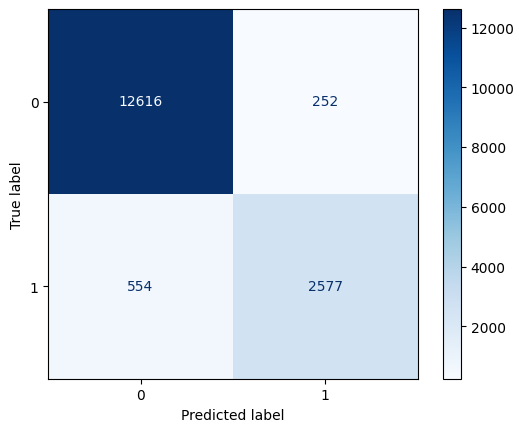

In [39]:
# Crear matriz de confusión
cm = confusion_matrix(y_val, y_pred)

# Mostrar gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

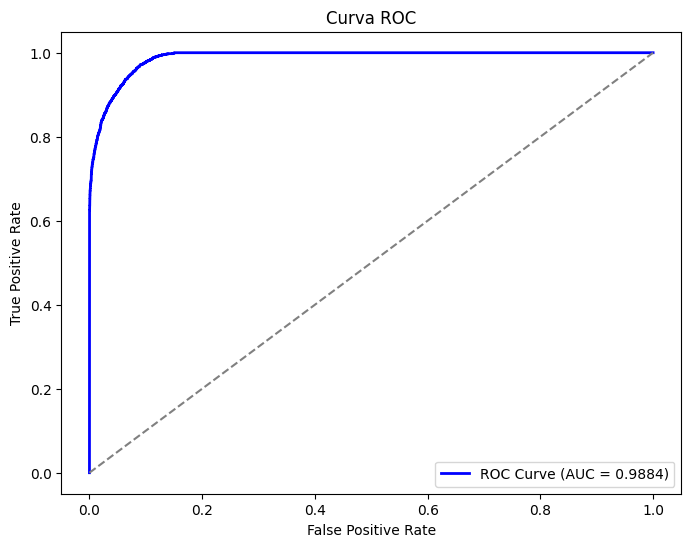

In [40]:
# Obtener probabilidades de predicción
y_probs = best_lgb.predict_proba(X_val)[:, 1]

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

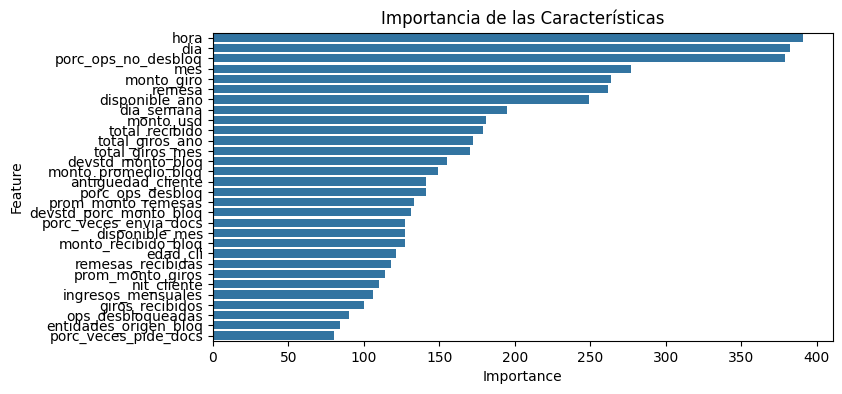

In [41]:
# Visualizar la importancia de las características
feature_importances = best_lgb.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(30))
plt.title("Importancia de las Características")
plt.show()

## Predicciones de la variable "y_desbloqueo" para el set de datos Base_test

In [42]:

# Copiar df_test a X_test para no modificar el original
X_test = df_test.copy()

### 🔹 Reducir uso de memoria en columnas numéricas
for col in X_test.select_dtypes(include=['float64']).columns:
    X_test[col] = X_test[col].astype('float32')
'''
### 🔹 Convertir variables categóricas en categorías
for col in X_test.select_dtypes(include=['object']).columns:
    X_test[col] = X_test[col].astype('category')

# 🔹 Asegurar que las categorías en base_test sean las mismas que en base_entrenamiento
for col in X_train.select_dtypes(include=['category']).columns:
    X_test[col] = X_test[col].astype('category').cat.set_categories(X_train[col].cat.categories)

### 🔹 Manejo de valores nulos antes de predecir
for col in X_test.columns:
    if X_test[col].isnull().any():  # Si la columna tiene valores nulos
        if X_test[col].dtype.name == 'category':
            # ✅ Agregar "DESCONOCIDO" a las categorías antes de reemplazar los nulos
            X_test[col] = X_test[col].cat.add_categories("DESCONOCIDO").fillna("DESCONOCIDO")
        else:
            X_test[col] = X_test[col].fillna(X_test[col].median())  # Rellenar numéricos con la mediana

# 🔍 Verificar que ya no haya valores nulos
print("Valores nulos en X_test después de rellenar:", X_test.isnull().sum().sum())
'''
# 🔹 Generar predicciones
y_test_pred = best_lgb.predict(X_test)

# 🔹 Crear DataFrame con las predicciones
df_preds = pd.DataFrame({
    'referencia_giro': df_test['referencia_giro'].astype(str),  # Convertir a string para evitar errores
    'y_desbloqueo': y_test_pred.astype(int)  # Convertir predicciones a enteros
})

# 🔹 Guardar archivo CSV sin notación científica
df_preds.to_csv('submission.csv', index=False)

print("✅ Predicciones guardadas en 'submission.csv'")

# 🔍 Verificar estructura de salida
print(df_preds.dtypes)
print(df_preds.head())




Valores nulos en X_test después de rellenar: 0
✅ Predicciones guardadas en 'submission.csv'
referencia_giro    object
y_desbloqueo        int32
dtype: object
  referencia_giro  y_desbloqueo
0   6855f660d27a6             0
1     6a3c26ef4f4             0
2     f3ed1ce67a8             0
3   bf6b6c1da7b56             0
4        3c86c256             0


In [ ]:
print(f"Filas en X_test: {X_test.shape[0]}")
print(f"Filas en y_pred: {len(y_pred)}")


In [ ]:
print(f"Filas originales en df_test: {df_test.shape[0]}")
print(f"Filas actuales en X_test: {X_test.shape[0]}")


In [ ]:
print(set(X_train.columns) - set(X_test.columns))  # Columnas que faltan en X_test
print(set(X_test.columns) - set(X_train.columns))  # Columnas extra en X_test


In [ ]:
print("Valores nulos en X_test después del preprocesamiento:")
print(X_test.isnull().sum().sum())


In [ ]:
X_test = X_test.iloc[:len(y_pred)].copy()  # Ajusta X_test al tamaño de y_pred
X_test["y_desbloqueo"] = y_pred
X_test[["referencia_giro", "y_desbloqueo"]].to_csv("submission.csv", index=False)


In [64]:
import pandas as pd
import numpy as np
import joblib

# Cargar df_test sin modificar el original
X_test = df_test.copy()

# 1️⃣ Cargar los modelos y transformadores entrenados
ordinal_encoder = joblib.load('ordinal_encoder.pkl')
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')
model = joblib.load('random_forest.pkl')

# 2️⃣ Identificar columnas categóricas y numéricas
categorical_cols = X_test.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_test.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 3️⃣ Aplicar Ordinal Encoding a las columnas categóricas
if categorical_cols:
    X_test[categorical_cols] = ordinal_encoder.transform(X_test[categorical_cols])

# 4️⃣ Convertir a float32 para reducir memoria
X_test = X_test.astype('float32')

# 5️⃣ Normalizar variables numéricas
if numerical_cols:
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 6️⃣ Reemplazar valores infinitos y eliminar filas con NaN
X_test = X_test.replace([np.inf, -np.inf], np.nan).dropna()

# 7️⃣ Aplicar PCA
X_test_pca = pca.transform(X_test)

# 8️⃣ Generar predicciones
y_test_pred = model.predict(X_test_pca)

# 9️⃣ Crear DataFrame con la columna referencia_giro y las predicciones
df_preds = pd.DataFrame({
    'referencia_giro': df_test['referencia_giro'], 
    'y_desbloqueo': y_test_pred
})

# 🔟 Guardar el archivo CSV
df_preds["y_desbloqueo"] = df_preds["y_desbloqueo"].astype(int)
df_preds.to_csv("submission.csv", index=False)

print("Predicciones guardadas en 'submission.csv'")


FileNotFoundError: [Errno 2] No such file or directory: 'scaler.pkl'